# Assignment 10
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Part 1

### In this part of the assignment we are going to implement gradCAM with the help of VGG model trained in imagenet dataset. We have two objective mentioned below in this part of the assignment:
* Implement gradCAM for last layer and one layer before on any class image.
* Find  "sunglasses" in the given Tony Stark image using GradCAM

### To achieve these objective let's first import important libraries and VGG model:

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
from keras import backend as K
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
%matplotlib inline

### Now let'sload the VGG model and load the required image and rescale it to 224x224 on top of which we are going to apply gradCAM:

In [0]:
model = VGG16(weights="imagenet")
from skimage import io
cat = io.imread("https://secure.i.telegraph.co.uk/multimedia/archive/02351/cross-eyed-cat_2351472k.jpg")
cat = cv2.resize(cat, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

### Now let's check the model summary and check layer names to apply it to gradCAM:

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Now let's create a function for gradCAM which we are going to apply on image to see heatmap:

In [0]:
def applygradCAM(reqImage,layerName,No_of_Channel_in_Layer):
  x = image.img_to_array(reqImage)
  # expanding dimension for prediction
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  # prediction of the image
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  
  # Getting the output of the last convolutional layer 
  last_conv_layer = model.get_layer(layerName)
  
  # Claculating the gradients
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(No_of_Channel_in_Layer):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  # Creating the heatmap
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  # Resize heatmap to original image size
  heatmap = cv2.resize(heatmap, (reqImage.shape[1], reqImage.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(reqImage, 0.5, heatmap, 0.5, 0)
  return superimposed_img

### Now let's create a dictionary of last 4 layer names and its channel length:

In [0]:
layer_names = {'block4_conv3': 512,'block5_conv1':512,'block5_conv2':512,'block5_conv3':512}

### Now let's store our original cat image and convolution layer gradCAM images in a variable:

In [0]:
img_gradCam_cat = []
img_gradCam_cat.append(cat)
for layer,no_of_channel in layer_names.items(): 
  img_req_grad = applygradCAM(cat,layer,no_of_channel)
  img_gradCam_cat.append(img_req_grad)

### So, let's see the last four layer gradCAM output of out cat image:

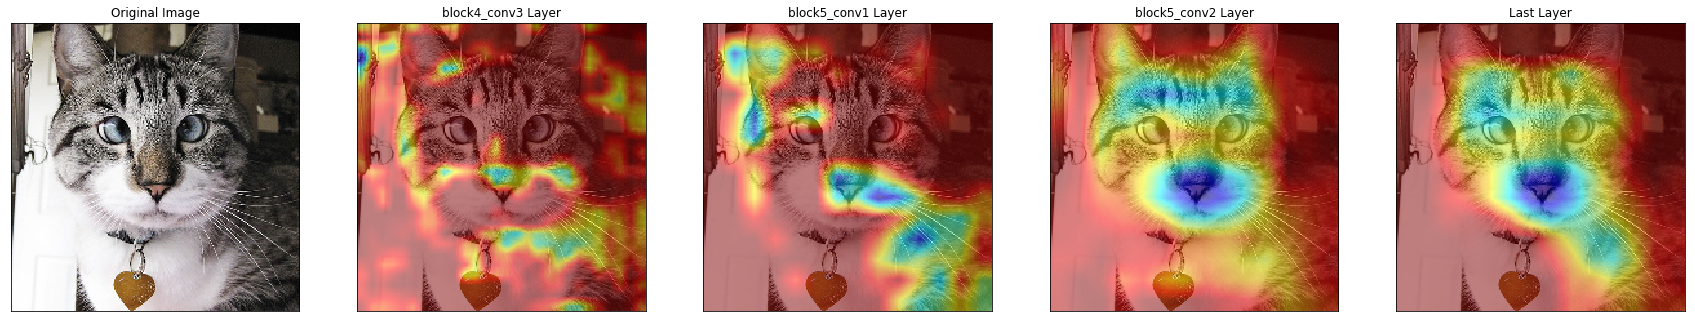

In [81]:
image_layers = ['Original Image','block4_conv3 Layer','block5_conv1 Layer','block5_conv2 Layer', 'Last Layer']
row = 1
col = 5
fig=plt.figure(figsize=(30,30))
for i in range(0,col):
  fig.add_subplot(1,col,i+1)
  plt.imshow(img_gradCam_cat[i]) 
  plt.title(image_layers[i])
  plt.xticks([])
  plt.yticks([])
plt.show()

### So, in the above we can see the gradCAM images of different layer on top our cat images.

### Now, to achieve our 2nd objective i.e. find  "sunglasses" in the given Tony Stark image using GradCAM, let's first load the image and resize it to 224x224.

In [75]:
!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
TonyStark = io.imread("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")
TonyStark = cv2.resize(TonyStark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

--2019-07-02 12:57:03--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.244.83, 190.93.245.83, 141.101.114.84, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.244.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.2’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.01s   

2019-07-02 12:57:03 (4.81 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.2’ saved [58670/58670]



### Now let's store our original Tony Stark image and convolution layer gradCAM images in a variable:

In [0]:
img_gradCam_TonyStark = []
img_gradCam_TonyStark.append(TonyStark)
for layer,no_of_channel in layer_names.items(): 
  img_req_grad = applygradCAM(TonyStark,layer,no_of_channel)
  img_gradCam_TonyStark.append(img_req_grad)

### Now, let's see the last four layer gradCAM output of out Tony Stark image and let's check if last layer of gradCAM can detect the sunglasses in the image:

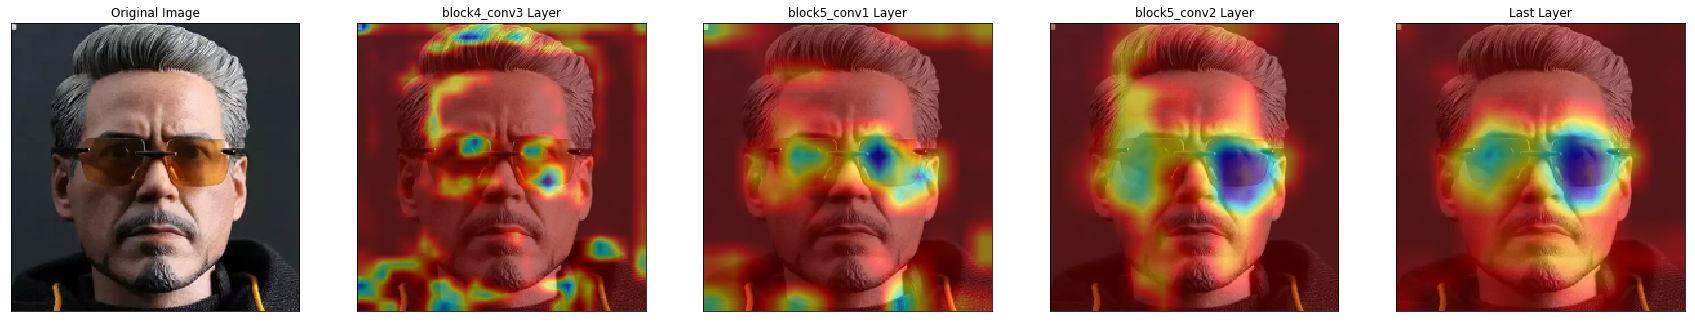

In [82]:
row = 1
col = 5
fig=plt.figure(figsize=(30,30))
for i in range(0,col):
  fig.add_subplot(1,col,i+1)
  plt.imshow(img_gradCam_TonyStark[i]) 
  plt.title(image_layers[i])
  plt.xticks([])
  plt.yticks([])
plt.show()

### So, from the above we can see that in the final layer of out Tony Stark image we can detect sunglasses with the help of gradCAM.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Part 2

### In this part of the assignment we need to explain the increase in receptive field in the mentioned paper.

### Let's first look at the details of receptive field in the below table:
![alt text](https://github.com/santuhazra1/TSAI_EVA_PHASE_1/blob/master/Session%2010/Images/21-Table7-1.png)

### So, from the above we can see receptive field from convolution 6 to 7 changes from 29 to 45 which we need to explain in this part of the assignment. Also, we can see that here receptive field is 3D in nature. Now, to explain the change in receptive field in detail let's look at the model architecture below:
######'
![alt text](https://github.com/santuhazra1/TSAI_EVA_PHASE_1/blob/master/Session%2010/Images/21-Figure17-1.png)

### So, from the the above we can see that our first convolutional layer is a 3x3 convolution with 1 stride. After that we can see that it is followed by 3 contracting block which is a combination of a 3x3 convolution with stride 2 followed by a 3x3 convolution with stride 1. Now, we know formula for output image size, receptive field and jump are as follows:
![alt text](https://github.com/santuhazra1/TSAI_EVA_PHASE_1/blob/master/Session%2010/Images/formula.png)

### Now, let's see in the below table how receptive field and jump is changing in each step:
![alt text](https://github.com/santuhazra1/TSAI_EVA_PHASE_1/blob/master/Session%2010/Images/table_calc.png)

### So, from the above table we can see that layer before last step jump was 8 and receptive field value was 29. So, in the next step 3x3 convolution with 1 stride we can say:
### Receptive field = 29 + (3-1) x 8 = 45
### So, from the from the above we can conclude in step 7 receptive field should be 45x45x45.


